In [17]:
# Run kfold
import json
import numpy as np
import matplotlib.pyplot as plt

test_scores_path = "models/20240413_153419/test_scores.json"

with open(test_scores_path, "r") as f:
    test_scores = json.load(f)


kfold_accuracy = np.array([elem['acc'] for elem in test_scores])
kfold_precision = np.array([elem['prec'] for elem in test_scores])
kfold_recall = np.array([elem['rec'] for elem in test_scores])
k = len(test_scores)
print(f"{k}-fold Avg. Accuracy:\t{100*kfold_accuracy.mean():.1f}% \n"
      f"{k}-fold Avg. Precision:\t{100*kfold_precision.mean():.1f}% \n"
      f"{k}-fold Avg. Recall:\t{100*kfold_recall.mean():.1f}%")



10-fold Avg. Accuracy:	98.3% 
10-fold Avg. Precision:	96.8% 
10-fold Avg. Recall:	98.7%


Model Number: H10 
Manufacturer Name: Polar Electro Oy 
Serial Number: 79324520 
Address: F3:6D:6E:2F:7C:18
Battery Level: 100%
Firmware Revision: 5.0.0 
Hardware Revision: 00760690.03 
Software Revision: 3.1.1 


Recording...: 100%|██████████| 20/20 [00:20<00:00,  1.00s/it]

Stopping ECG data...


(2555,)
(2555,)


In [ ]:
# Displaying the Receiver Operating Characteristic
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_scores = model.predict(X_test, verbose=0)
y_scores = y_scores.flatten()
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--', color='black')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f"AUC: {auc:.4f}")


In [3]:
# Randomly load in either a AF or Normal ECG

from dataloading import *
from preprocessing import *
import os

db_dir = "data/physionet"
pkl_path = db_dir + "normalisedrecords_fslist_labels.pkl"
cutoff = 60 # Hz
resample_fs = 120 # Hz
crop_length = 30 # s
afib_dup_factor = 3

if not os.path.exists(pkl_path):
    # Read filter, and normalise
    record_list, fs_list, labels = read_challenge17_data(db_dir)
    resampled_records = lowpass_filter_and_resample_record_list(record_list, fs_list, 512, cutoff, resample_fs)
    normalised_records = normalise_record_list(resampled_records)
    # Save it out 
    save_challenge17_pkl(pkl_path, (normalised_records, fs_list, labels))
else:
    # Read in the pkl file
    normalised_records, fs_list, labels = load_challenge17_pkl(pkl_path)

normalised_records, labels = drop_other_class_records_and_labels(normalised_records, labels)
dup_records, labels = duplicate_afib_records_in_list(normalised_records, labels, afib_dup_factor)
records = crop_and_pad_record_list(dup_records, resample_fs, crop_length)


(1, 3601, 1)


2024-04-20 11:24:49.507019: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 209715200 exceeds 10% of free system memory.
2024-04-20 11:24:49.904187: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


1/1 [==============================] - 1s 771ms/step


Text(0.5, 1.0, 'Case: A, Prediction: A')

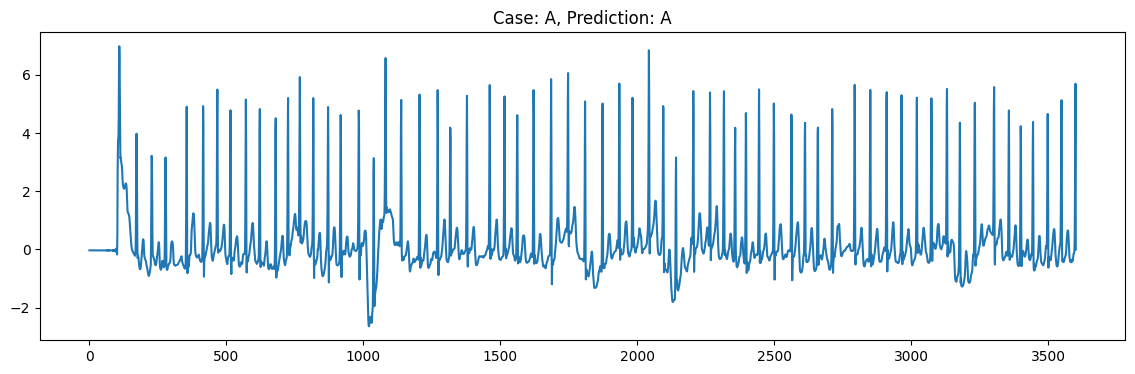

In [6]:
# Randomly select an index of the True AF column
import random
import matplotlib.pyplot as plt
from modelling import *
import numpy as np

CASE = 'A' # A (Atrial Fibrillation) or N (Normal)
models_path = "models/20240413_153419/fold_9_model_weights.h5"

X = np.array(records)
X = np.expand_dims(X, -1)

# Select a random case
case_ids = labels[labels[CASE]].index
rand_case_id = random.choice(case_ids)
case_signal = X[rand_case_id:rand_case_id+1]
print(case_signal.shape)

# Load the model
model = create_dual_stream_cnn_model((X.shape[1], 1), stream2_size=7, verbose=0)
model.load_weights(models_path)

prediction = model.predict(case_signal)
predicted_class = "Atrial Fibrillation" if prediction >=0.5 else "Normal"

plt.figure(figsize=(14,4))
plt.plot(case_signal.flatten())
plt.title(f"Case: {CASE}, Prediction: {predicted_class}")